# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing

#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

In [3]:
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt

In [4]:
import problem_unittests as tests

In [5]:
# necessary imports
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms as T

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [6]:
def get_dataloader(batch_size,
                   image_size,
                   data_dir= 'processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    
    :return: DataLoader with batched data
    """
    # Define transformer.
    transform = T.Compose([T.Resize(image_size), T.ToTensor()])
    data = datasets.ImageFolder(data_dir, transform)
    loader_data =  torch.utils.data.DataLoader(data, batch_size= batch_size, shuffle= True)
    
    return loader_data


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [7]:
# Define function hyperparameters
batch_size = 64
img_size = 32 

# Get a dataloader.
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

In [8]:
# helper display function
def imshow(img):
    """Display Image."""
    # @TODO: see how you can improve the function.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

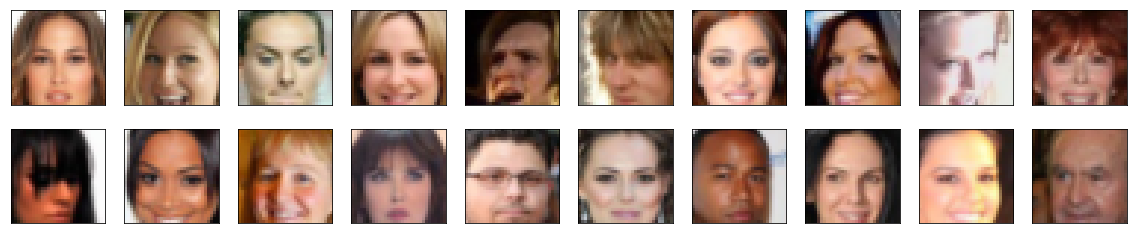

In [9]:
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize= (20, 4))
plot_size=20
for ix in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, ix+1, xticks=[], yticks=[])
    imshow(images[ix])

#### Pre-process the image data and scale it to a pixel range of -1 to 1

The output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.) Therefore some pre-processing is in order.

In [10]:
def scale(x, feature_range= (-1, 1)):
    """Scale takes in an image x and returns that image, scaled
    with a feature_range of pixel values from -1 to 1. 
    This function assumes that the input x is already scaled from 0-1.
    """
    scaled_x = np.interp(x, (x.min(), x.max()), (-1, +1))
    # Convert from numpy to Tensor    
    scaled_x = torch.from_numpy(scaled_x)
    # The weights in model are FlaotTensor,
    # Otherwise, complains that input type and weight type differ.
    # As is, now scaled_x is DoubleTensor.
    return scaled_x.float()


In [11]:
# check scaled range
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [12]:
def conv(in_channels, out_channels, kernel_size= 4,
         stride= 2, padding= 1, batch_norm= True):
    """ Helper function for the Discriminator.
    Creates a convolutional layer, with optional batch normalization.
    
    Note: the default parameters for kernel_size, stride & padding
    make sure that each strided conv-layer downsamples its imput
    by a factor of 2 in the X and Y dimensions.
    """
    # Initialize the list of layers with an empty list
    layers = []
    # Define the strided convolutional layer
    # Set the bias to False so that the layers are not offset by any amount.
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size= kernel_size, stride= stride, padding= padding,
                           bias= False)

    # Append the convolutional layer to the list of layers.
    layers.append(conv_layer)

    if batch_norm:
        # Add a batch-norm layer on the output of the conv-layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        
        :param conv_dim: The depth of the first convolutional layer
        """
        nn.Module.__init__(self)
        self.conv_dim = conv_dim
        
        # The idea is as the conv layers reduce in spatial size by a factor of two
        # Double the number of channels in each next layer.
        self.conv1 = conv(3, conv_dim, batch_norm= False)
        self.conv2 = conv(conv_dim, conv_dim * 2)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4)
        
        # Define the final fully-connected layers to classify.
        ## For SVHD data, the input size is 32x32.
        ## After 3 conv-layer, the size will decrease to
        ## 32 -> 16(first conv-layer output) -> 8 -> 4
        # (conv_dim * 4) is the number of channels in the last conv-layer.
        self.fc = nn.Linear((conv_dim * 4) * (4 * 4), 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        
        :param x: The input to the neural network
        
        :return: Discriminator logits; the output of the neural network
        """
        s = .2 # negative slope for leaky-relu
        x = F.leaky_relu(self.conv1(x), s)
        x = F.leaky_relu(self.conv2(x), s)
        x = F.leaky_relu(self.conv3(x), s)
        
        # Flatten the output from the final conv-layer.
        ## (self.conv_dim * 4) * (4*4) is:
        ## the depth of last layer * (image-size from last layer)
        x = x.view(-1, (self.conv_dim * 4) * (4*4))
        
        # Return the discriminator logit.
        return self.fc(x)


In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [15]:
def deconv(in_channels, out_channels, kernel_size= 4,
           stride= 2, padding= 1, batch_norm= True):
    """ Helper function for the Generator.
    Creates a conv-transpose layer, with optional batch normalization.
    
    Note: the default parameters for kernel_size, stride & padding
    effectively upsample the inputs by a factor of 2 in the <x, y> dimension.
    """
    # Initialize the list of layers with an empty list
    layers = []
    # Define the convolutional-transpose layer
    # Set the bias to False so that the layers are not offset by any amount.
    tconv_layer = nn.ConvTranspose2d(in_channels, out_channels,
                                     kernel_size= kernel_size, stride= stride,
                                     padding= padding, bias= False)

    # Append the conv-transpose layer to the list of layers.
    layers.append(tconv_layer)

    if batch_norm:
        # Add a batch-norm layer on the output of the tconv-layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [16]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module.
        
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        nn.Module.__init__(self)
        self.conv_dim = conv_dim
        
        # The final layer has to be 3 channels and size of 32 x 32.
        ## Therefore, to be able to get there with 3 tconv layer
        ## We need to start with 128; 128 -> 64 -> 32.
        ## 128 = 32 * 4 (pass conv_dim as 32).
        self.fc = nn.Linear(z_size, (conv_dim * 4) * (4 * 4))
        
        # Define the transposed conv layers.
        self.tconv1 = deconv(conv_dim * 4, conv_dim * 2)
        self.tconv2 = deconv(conv_dim * 2, conv_dim)
        # The final layer makes sure that the output is of desired shape.
        # For SVHN data, this is 32x32x3 (size of 32, in RGB format).
        # Hence the out_channel is 3 here, and we originally passed conv_dim as 32.
        self.tconv3 = deconv(conv_dim, 3, batch_norm= False)      
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        
        :param x: The input to the neural network
        
        :return: A 32x32x3 Tensor image as output
        """
        x = self.fc(x)
        # Reshape the output to the required format.
        # <batch_size, depth, x, y>, here <batch_size, 128, 4, 4>
        x = x.view(-1, self.conv_dim * 4, 4, 4)
        
        # Pass the output through the tconv layers.
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        # For last layer, tanh activation function needs to be applied.
        #=> Now, the output is <32, 32, 3> in shape,
        # and with pixel values in a range from -1 to 1.
        x = F.tanh(self.tconv3(x))
        
        return x


In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [18]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Apply initial weights only to convolutional and linear layers.
    is_conv = classname.find('Conv') != -1
    is_linear = classname.find('Linear') != -1
    
    if hasattr(m, 'weight') and (is_conv or is_linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m.bias, 'data'):
            # Set the bias to 0.
            nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size= z_size, conv_dim= g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)
    
    return D, G


#### Exercise: Define model hyperparameters

In [20]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

# Build the network
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

In [21]:
# Make sure the Discriminator is instantiated as expected.
# e.g., no batch-normalization is applied to the first and last layer.
print(D)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


In [22]:
# Make sure the Generator is instantiated as expected.
print(G)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


### Training on GPU

Check if you can train on GPU. Later, Make sure that the followings are moved to GPU, whereappropriate.
>* Models,
* Model inputs, and
* Loss function arguments


In [23]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Complete real and fake loss functions


In [24]:
def real_loss(D_out, smooth= False):
    """ Calculates how close discriminator outputs are to being real.
    param, D_out: discriminator logits
    return: real loss
    """
    batch_size = D_out.size(0)
    # real labels = 1
    labels = torch.ones(batch_size)
    if smooth:
        # smooth, real labels = 0.9
        labels *= .9
    
    # Move labels to GPU if available.
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # Calculate loss.
    loss = criterion(D_out.squeeze(), labels)
    return loss

    
def fake_loss(D_out):
    """ Calculates how close discriminator outputs are to being fake.
    param, D_out: discriminator logits
    return: fake loss
    """
    batch_size = D_out.size(0)
    # fake labels = 0
    labels = torch.zeros(batch_size)
    # Move labels to GPU if available.
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    # Calculate loss.
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Define optimizers for the Discriminator (D) and Generator (G)

In [25]:
# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1= 0.5
beta2= 0.999 # default value

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use the functions `real_loss` and `fake_loss` to calculate the discriminator losses. Training happens as follow:

* Train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

#### Saving Samples

Also print out some loss statistics and save some generated "fake" samples.

#### Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [26]:
def train(D, G, n_epochs, print_every= 200):
    """ Trains adversarial networks for some number of epochs.
    
    param, D: the discriminator network
    param, G: the generator network
    param, n_epochs: number of epochs to train for
    param, print_every: when to print and record the models' losses
    
    return: D and G losses
    """
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            # important rescaling step: -1 to 1
            real_images = scale(real_images)

            # 1. Train the discriminator on real and fake images. ======
            d_optimizer.zero_grad()
            
            # 1.a. Train with real images. -----
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # Compute the discriminator losses on real images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # 2. Train with fake images. -----
            z = np.random.uniform(-1, 1, size= (batch_size, z_size))
            z = torch.from_numpy(z).float()
            # Move z to GPU, if available
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z) 
            
            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # Add up loss and perform backprop.
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss =========
            g_optimizer.zero_grad()
        
            # 2.a. Train with fake images and flipped labels. -----

            # Generate fake images
            z = np.random.uniform(-1, 1, size= (batch_size, z_size))
            z = torch.from_numpy(z).float()
            # Move to GPU if available.
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)

            # Compute the discriminator losses on fake images using flipped labels!
            D_fake = D(fake_images)
            # use real loss to flip labels
            g_loss = real_loss(D_fake)

            # Perform backprop.
            g_loss.backward()
            g_optimizer.step() 
            

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples.
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # Return losses.
    return losses

Set your number of training epochs and train your GAN!

In [27]:
# set number of epochs 
n_epochs = 1

# call training function
losses = train(D, G, n_epochs= n_epochs)

Epoch [    1/    1] | d_loss: 1.3829 | g_loss: 0.7880
Epoch [    1/    1] | d_loss: 0.1518 | g_loss: 3.3170
Epoch [    1/    1] | d_loss: 1.3914 | g_loss: 3.8189
Epoch [    1/    1] | d_loss: 0.6886 | g_loss: 1.6303
Epoch [    1/    1] | d_loss: 1.4771 | g_loss: 0.8249
Epoch [    1/    1] | d_loss: 1.2094 | g_loss: 0.8417
Epoch [    1/    1] | d_loss: 1.1184 | g_loss: 1.4579
Epoch [    1/    1] | d_loss: 1.0713 | g_loss: 1.0488


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

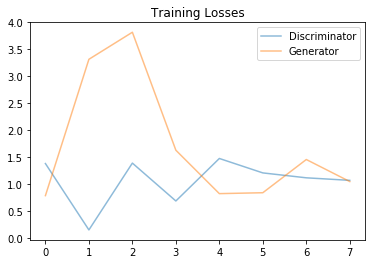

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [29]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [30]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

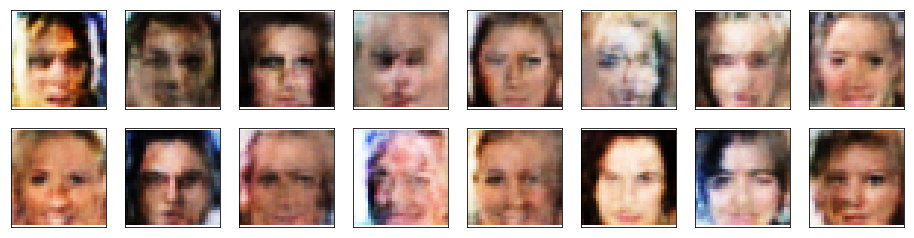

In [31]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)